## This notebook compare simulation results to experiments - 2C GITT

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

# Add path to system to ensure Fun_NC can be used
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(
    os.path.join(str_path_0,"Reproduce_Li2024"))
sys.path.append(str_path_1) 
Path_Input = os.path.expanduser(
    "~/EnvPBGEM_NC/SimSave/InputData/") # for Linux
BasicPath =  os.path.expanduser(
    "~/EnvPBGEM_NC/SimSave/Li2024_Results")

# import all functions 
from Fun_NC import * 


In [3]:
model_sei_hy = pb.lithium_ion.DFN(
    options={
    "SEI": "interstitial-diffusion limited",
    "SEI on cracks": "true",
    
    "lithium plating": "none",
    "lithium plating porosity change":"false",
    "particle mechanics": "constant cracks",
    "loss of active material": "none",

    "contact resistance": "true",
    "open-circuit potential": "current sigmoid",
    "SEI film resistance": "distributed", 
    "SEI porosity change": "true",
    "thermal": "lumped",  
    }, )


Para_All = []
param = pb.ParameterValues("OKane2023")
para_dict = {
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    #'Initial electrolyte excessive amount ratio':1.0, 
    "Contact resistance [Ohm]": 0.0115, # 0.016, # 
    'Inner SEI lithium interstitial diffusivity [m2.s-1]':2.35555E-18, 

    'Outer SEI partial molar volume [m3.mol-1]':4E-05,
    "SEI growth activation energy [J.mol-1]":1e4,
    "Negative electrode diffusivity activation energy [J.mol-1]":6e4,
    "Positive electrode diffusivity activation energy [J.mol-1]":1.2e4,
}
for key, value in para_dict.items():
    param.update({key: value})

V_max = 4.2;        V_min = 2.5
exp_topup_text = [ (
    f"Discharge at 0.5C until {V_max-0.2}V", # start from discharge as it is easier for unbalanced cells
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours", 
    ) ] 
exp_GITT_text = [ (
    "Rest for 60 seconds (1 second period)", 
    "Discharge at 2C for 72 seconds or until 2.5V (0.1 second period)", 
    "Rest for 1 hour (1 second period)"
    ) ]

experiment = pb.Experiment( 
    exp_topup_text * 1 + exp_GITT_text * 25 ) 
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 80,  # negative particle
    "r_p": 20,  # positive particle
}


In [5]:
param["Negative electrode diffusivity [m2.s-1]"]

<function pybamm.input.parameters.lithium_ion.OKane2023.graphite_LGM50_diffusivity_ORegan2022(sto, T)>

In [6]:
# run pybamm model
sim = pb.Simulation(
    model_sei_hy, 
    experiment = experiment,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts, )
sol = sim.solve(calc_esoh=False,)

At t = 66.5934, , mxstep steps taken before reaching tout.
At t = 66.5934, , mxstep steps taken before reaching tout.
At t = 66.5934, , mxstep steps taken before reaching tout.
At t = 66.5934 and h = 1.01682e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 39.054, , mxstep steps taken before reaching tout.
At t = 39.054, , mxstep steps taken before reaching tout.
At t = 39.054, , mxstep steps taken before reaching tout.
At t = 39.054, , mxstep steps taken before reaching tout.
At t = 29.2279, , mxstep steps taken before reaching tout.
At t = 29.2279, , mxstep steps taken before reaching tout.
At t = 29.2279, , mxstep steps taken before reaching tout.
At t = 29.2279 and h = 6.23342e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 29.2279, , mxstep steps taken before reaching tout.


In [7]:
len(sol.cycles)

26

In [8]:
# import experimental GITT data from file
GITT_data = pd.read_csv(
    Path_Input + "LG_M50_BOL_GITT/2C_GITT_25deg.csv", comment="#", header=None
).to_numpy()
t_exp = GITT_data[:,0]/3600
I_exp = -GITT_data[:,3]/1000
V_exp = GITT_data[:,2]
#Q_exp = GITT_data[:,1]/1000
Q_exp = []
for i in range (len(t_exp)):
    Q_temp = np.trapz(I_exp[0:i],t_exp[0:i])
    Q_exp.append(Q_temp)

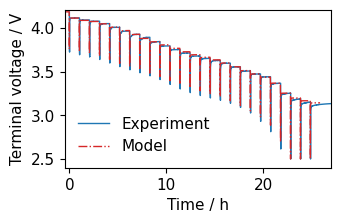

In [15]:
# Fig.1 - (a) Overall:
def Plot_Comp_GITT_Overall(sol, Save_Fig, fig_name):
    # Plot setting
    font = {'family' : 'DejaVu Sans', 'size' : 11}
    mpl.rc('font', **font)
    lw=1
    Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e']
    # Date pre-processing
    t_exp_hours = t_exp-t_exp[0];
    # sol = DD_Dis_All[0]
    t_seconds = sol["Time [s]"].entries
    t_sim_start = sol.cycles[1].steps[2]["Time [s]"].entries[0]  # shift
    t_hours = (t_seconds - t_sim_start) / 3600
    I = sol["Current [A]"].entries
    Q = sol["Discharge capacity [A.h]"].entries
    V = sol["Terminal voltage [V]"].entries

    fig, ax = plt.subplots(figsize=(9/2.54,6/2.54),tight_layout=True)
    ax.plot(
        t_exp_hours,V_exp, color=Colors[0],
        linewidth=lw,
        linestyle='-',label='Experiment')
    ax.plot(
        t_hours,V,color=Colors[2],linewidth=lw,    
        linestyle='-.',label='Model')

    ax.set_xlabel('Time / h')
    ax.set_ylabel('Terminal voltage / V')
    plt.xlim(-0.5,27)
    plt.ylim(2.4,4.21)
    #ax.set_title('25x1C pulses at 298K, comparison')
    ax.legend(loc='best',frameon=False)
    if Save_Fig:
        plt.savefig(fig_name + '.png', dpi=600)
        plt.savefig(fig_name + '.svg')  
    return 

Save_Fig = True; 
Plot_Comp_GITT_Overall(
    sol, Save_Fig, fig_name = (
        BasicPath + "/SaveFig/GITT_Validation/" 
        + "GITT_2C_discharge_298K" ) ) 


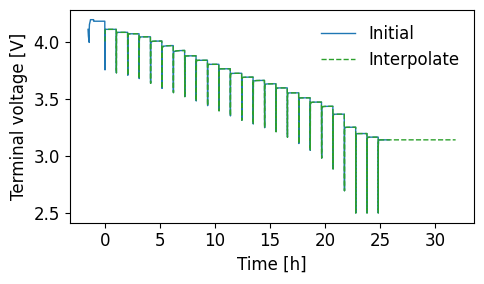

In [19]:
# to calculate RMSE 
font = {'family' : 'DejaVu Sans', 'size' : 12}
mpl.rc('font', **font)
lw=1;
Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
# interpolate expeirment data to align with simulation
def calculate_mpe_mape(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError("The length of actual and predicted lists must be the same.")
    if 0 in actual:
        raise ValueError("Actual values contain zero, which will lead to division by zero in MAPE calculation.")

    mpe_sum = 0
    mape_sum = 0
    n = len(actual)

    for a, p in zip(actual, predicted):
        mpe_sum += (a - p) / a
        mape_sum += abs((a - p) / a)

    mpe = (mpe_sum / n) * 100
    mape = (mape_sum / n) * 100

    return mpe, mape

def Inter_Plot(sol,Save_Fig,fig_name):
    t_exp_hours = t_exp-t_exp[0]
    t_seconds = sol["Time [s]"].entries
    t_sim_start = sol.cycles[1].steps[2]["Time [s]"].entries[0]  # shift
    t_hours = (t_seconds - t_sim_start) / 3600
    V = sol["Terminal voltage [V]"].entries
    V_exp_int1 = np.interp(t_exp_hours,t_hours,V) 
    # %matplotlib qt
    fig, ax = plt.subplots(figsize=(5,3),tight_layout=True)
    ax.plot(
        t_hours,V, color=Colors[0],
        linewidth=lw,
        linestyle='-',label='Initial')
    ax.plot(
        t_exp_hours,V_exp_int1, color=Colors[1],
        linewidth=lw,
        linestyle='--',label='Interpolate')
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Terminal voltage [V]')
    #Xlim=(-0.01,0.06) ; Ylim = (3.6,4.24)
    #plt.xlim(Xlim)
    #plt.ylim(Ylim)
    
    ax.legend(loc='best',frameon=False)
    if Save_Fig:
        plt.savefig(fig_name + '.png',dpi=600)
        plt.savefig(fig_name + '.svg')  
    rmse = np.sqrt(np.mean((V_exp_int1-V_exp)**2))
    mpe, mape = calculate_mpe_mape(V_exp, V_exp_int1)
    return t_hours,V_exp_int1,rmse,mpe, mape
SD_V_exp_int1_List = []; SD_RMSE_List = []; 
SD_MPE_List = []; SD_MAPE_List = []; 

for i in range(1):
    t_hours,V_exp_int1,rmse,mpe, mape = Inter_Plot(
        sol, Save_Fig, BasicPath + "/SaveFig/GITT_Validation/" 
        + f"GITT_2C_get_RMSE")
    SD_V_exp_int1_List.append(V_exp_int1)
    SD_RMSE_List.append(rmse)
    SD_MPE_List.append(mpe)
    SD_MAPE_List.append(mape) #"""

In [21]:
SD_RMSE_List[0]

np.float64(0.18481718634941813)

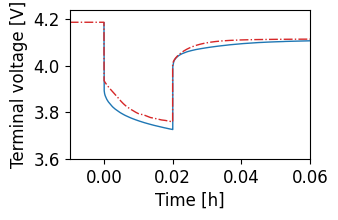

In [11]:
# zoom in:
lw = 1
def Plot_compare_zoom ( sol, Xlim, Ylim):
    Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
    t_exp_hours = t_exp-t_exp[0];
    t_seconds = sol["Time [s]"].entries
    # shift the modelling time to t=0 to be first discharge
    t_sim_start = sol.cycles[1].steps[1]["Time [s]"].entries[0] 
    t_hours = (t_seconds - t_sim_start) / 3600
    I = sol["Current [A]"].entries
    Q = sol["Discharge capacity [A.h]"].entries
    V = sol["Terminal voltage [V]"].entries

    fig, ax = plt.subplots(figsize=(9/2.54,6/2.54),tight_layout=True)
    ax.plot(
        t_exp_hours,V_exp, color=Colors[0],
        linewidth=lw,
        linestyle='-',label='Experiment')
    ax.plot(
        t_hours,V,color=Colors[2],linewidth=lw,    
        linestyle='-.',label='Model')

    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Terminal voltage [V]')
    # plt.xlim(-0.5,27)
    # plt.ylim(2.4,4.21)
    plt.xlim(Xlim)
    plt.ylim(Ylim)
    #ax.set_title('25x1C pulses at 298K, comparison')
    #ax.legend(loc='best',frameon=False)
    return 
Xlim=(-0.01,0.06)  
Ylim = (3.6,4.24)
k=1

Plot_compare_zoom ( sol, Xlim, Ylim)



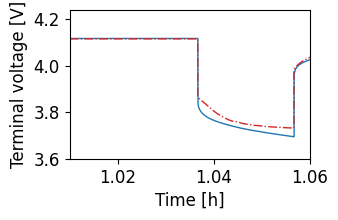

In [12]:
Xlim=(1.01,1.06)  
Ylim = (3.6,4.24)

Plot_compare_zoom ( sol, Xlim, Ylim)

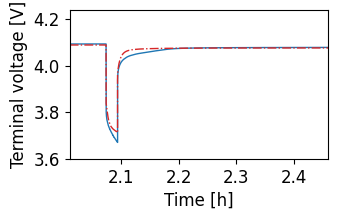

In [13]:
Xlim=(2.01, 2.46)  
Ylim = (3.6,4.24)  

Plot_compare_zoom ( sol, Xlim, Ylim)